# Session 14: MCP-Powered X Post Summarizer

## Building a LangGraph Agent with GitHub MCP Tools, X API Tools, and Memory

## Learning Objectives:

- **Ingest MCP servers as LangGraph tools** using `langchain-mcp-adapters` to connect to the GitHub MCP Server and use its tools programmatically
- **Wrap the X (Twitter) API as a LangChain tool** using the `@tool` decorator so a LangGraph agent can search and retrieve public posts
- **Build a LangGraph agent with memory** that combines MCP-sourced tools and custom tools, using `MemorySaver` for short-term conversational memory
- **Orchestrate a full workflow through the agent** — search X posts, generate summaries, create a GitHub repo, commit files, branch, and open a PR — all via natural language

## Overview

In this notebook, you will build a **LangGraph ReAct agent** that has access to two categories of tools:

1. **GitHub MCP tools** — loaded from the official GitHub MCP Server via `langchain-mcp-adapters`. These replace manual `git` commands with tool calls the agent can invoke (create repos, commit files, create branches, open PRs).
2. **X API tools** — custom Python functions wrapped with the `@tool` decorator that call the X API v2 directly to search and retrieve posts.

The agent uses **`MemorySaver`** for short-term memory so it can maintain context across multi-step workflows within a conversation thread.

There will be one breakout room with two phases:

- 🤝 Phase 1: Setup, Tools & Agent Construction
  - Task 1: Dependencies & Environment
  - Task 2: X API as LangChain Tools
  - Task 3: Connect to GitHub MCP Server & Load Tools
  - Task 4: Build the LangGraph Agent with Memory
  - Task 5: Test the Agent — Search & Summarize X Posts
  - Activity #1: Extend the Agent with a Custom X API Tool
- 🤝 Phase 2: MCP Workflow Through the Agent
  - Task 6: Create a GitHub Repository
  - Task 7: Commit the Summary
  - Task 8: Create a Feature Branch & Add Metadata
  - Task 9: Open a Pull Request
  - Task 10: Commit the X API Script
  - Task 11: Update the README
  - Activity #1: Multi-Account Comparison Pipeline

---

# 🤝 Breakout Room 
## Setup, Tools & Agent Construction

## Task 1: Dependencies & Environment

We need:
- `langchain-mcp-adapters` to connect to MCP servers and convert their tools into LangChain tools
- `langgraph` for our agent graph with memory
- `langchain-openai` for our LLM
- `requests` for the X API calls
- `nest-asyncio` for async MCP operations inside Jupyter

> NOTE: Create a `.env` file in this directory with `X_BEARER_TOKEN`, `OPENAI_API_KEY`, and `GITHUB_PAT` before running.
> 
> Setup references:
> - GitHub fine-grained PAT guide: [Creating a personal access token](https://docs.github.com/en/authentication/keeping-your-account-and-data-secure/managing-your-personal-access-tokens#creating-a-fine-grained-personal-access-token)
> - X API Bearer Token setup: [X Developer Portal](https://developer.x.com/en/portal/dashboard) and [X API access tiers](https://developer.x.com/en/products/twitter-api)


In [1]:
from uuid import uuid4
import getpass
import os
from dotenv import load_dotenv
load_dotenv()

def get_api_key(env_var: str, prompt: str) -> str:
    """Get API key from environment or prompt user."""
    value = os.environ.get(env_var, "")
    if not value:
        value = getpass.getpass(prompt)
        if value:
            os.environ[env_var] = value
    return value

cohere_key = get_api_key("COHERE_API_KEY", "Cohere API Key: ")
if cohere_key:
    print("cohere API key set")
else:
    print("Warning: No Cohere API key configured")

# Set Anthropic API Key (default for Deep Agents)
anthropic_key = get_api_key("ANTHROPIC_API_KEY", "Anthropic API Key: ")
if anthropic_key:
    print("Anthropic API key set")
else:
    print("Warning: No Anthropic API key configured")

# Optional: OpenAI for alternative models and subagents
openai_key = get_api_key("OPENAI_API_KEY", "OpenAI API Key (press Enter to skip): ")
if openai_key:
    print("OpenAI API key set")
else:
    print("OpenAI API key not configured (optional)")

# Optional: LangSmith for tracing
langsmith_key = get_api_key("LANGCHAIN_API_KEY", "LangSmith API Key (press Enter to skip): ")

if langsmith_key:
    os.environ["LANGCHAIN_TRACING_V2"] = "true"
    os.environ["LANGCHAIN_PROJECT"] = f"AIE9 - Deep Agents - {uuid4().hex[0:8]}"
    print(f"LangSmith tracing enabled. Project: {os.environ['LANGCHAIN_PROJECT']}")
else:
    os.environ["LANGCHAIN_TRACING_V2"] = "false"
    print("LangSmith tracing disabled")

if not os.environ.get("METAL_API_KEY"):
    os.environ["METAL_API_KEY"] = getpass("Please enter your metals.dev API key!")

if not os.environ.get("X_BEARER_TOKEN"):
    os.environ["X_BEARER_TOKEN"] = getpass.getpass("Enter your X Bearer Token:")

if not os.environ.get("OPENAI_API_KEY"):
    os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API Key:")

if not os.environ.get("GITHUB_PAT"):
    os.environ["GITHUB_PAT"] = getpass.getpass("Enter your GitHub PAT:")

cohere API key set
Anthropic API key set
OpenAI API key set
LangSmith tracing enabled. Project: AIE9 - Deep Agents - e4efe392


In [2]:
import nest_asyncio
nest_asyncio.apply()  # Required for async operations in Jupyter

### Getting Your Credentials

**GitHub PAT (fine-grained):**
1. Open [GitHub Personal Access Tokens (fine-grained)](https://github.com/settings/personal-access-tokens/new).
2. Follow [GitHub's PAT setup guide](https://docs.github.com/en/authentication/keeping-your-account-and-data-secure/managing-your-personal-access-tokens#creating-a-fine-grained-personal-access-token).
3. Set repository permissions to at least:
   - `Contents`: Read and write
   - `Pull requests`: Read and write
   - `Metadata`: Read-only

**X Bearer Token:**
1. Open the [X Developer Portal](https://developer.x.com/en/portal/dashboard).
2. Create/select a Project + App, then go to **Keys and Tokens** to generate a Bearer Token.
3. Confirm your plan supports the recent search endpoint (`GET /2/tweets/search/recent`) from the [X API product page](https://developer.x.com/en/products/twitter-api).


In [3]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4.1-mini", temperature=0)

# Test the connection
response = llm.invoke("Say 'MCP agent ready!' in exactly those words.")
print(response.content)

MCP agent ready!


## Task 2: X API as LangChain Tools

Instead of relying on a community-built MCP server for X, we'll call the **X API v2** directly and wrap our functions with the `@tool` decorator. This makes them available to our LangGraph agent as callable tools — just like the MCP tools will be.

This is a key architectural decision: **not everything needs to be an MCP server**. Wrapping a simple API call as a `@tool` is often simpler and more transparent.

**📚 Documentation:**
- [LangChain Tools Conceptual Guide](https://python.langchain.com/docs/concepts/tools/)
- [X API v2 Documentation](https://developer.x.com/en/docs/x-api)

In [4]:
import requests
import json
from langchain_core.tools import tool

BEARER_TOKEN = os.environ.get("X_BEARER_TOKEN")


@tool
def search_recent_posts(query: str, max_results: int = 20) -> str:
    """Search recent X/Twitter posts using the v2 API.
    Returns posts from the last 7 days matching the query.
    Use this for keyword searches, hashtag searches, or general topic searches.

    Args:
        query: The search query (e.g., 'AI safety', '#machinelearning', 'from:AndrewYNg')
        max_results: Number of results to return (10-100, default 20)
    """
    url = "https://api.x.com/2/tweets/search/recent"
    headers = {"Authorization": f"Bearer {BEARER_TOKEN}"}
    params = {
        "query": query,
        "max_results": min(max(max_results, 10), 100),
        "tweet.fields": "created_at,public_metrics,author_id,text",
        "expansions": "author_id",
        "user.fields": "name,username",
    }

    response = requests.get(url, headers=headers, params=params)
    response.raise_for_status()
    data = response.json()

    tweets = data.get("data", [])
    if not tweets:
        return "No posts found for this query."

    result_lines = [f"Found {len(tweets)} posts:\n"]
    for t in tweets:
        metrics = t.get("public_metrics", {})
        result_lines.append(
            f"[{t.get('created_at', 'unknown')[:10]}] "
            f"{t['text'][:200]}\n"
            f"  Likes: {metrics.get('like_count', 0)} | "
            f"Retweets: {metrics.get('retweet_count', 0)}"
        )
    return "\n\n".join(result_lines)


@tool
def get_user_posts(username: str, max_results: int = 20) -> str:
    """Get recent original posts (no retweets) from a specific X/Twitter user.
    Use this when you want to see what a specific account has been posting.

    Args:
        username: The X/Twitter handle without the @ sign (e.g., 'AndrewYNg')
        max_results: Number of results to return (10-100, default 20)
    """
    query = f"from:{username} -is:retweet"
    return search_recent_posts.invoke({"query": query, "max_results": max_results})


x_api_tools = [search_recent_posts, get_user_posts]
print(f"Created {len(x_api_tools)} X API tools: {[t.name for t in x_api_tools]}")

Created 2 X API tools: ['search_recent_posts', 'get_user_posts']


Let's verify our X API tools work before wiring them into the agent:

In [5]:
# Quick test — fetch recent posts from a public account
result = get_user_posts.invoke({"username": "llm_wizard", "max_results": 10})
print(result[:500])

HTTPError: 402 Client Error: Payment Required for url: https://api.x.com/2/tweets/search/recent?query=from%3Allm_wizard+-is%3Aretweet&max_results=10&tweet.fields=created_at%2Cpublic_metrics%2Cauthor_id%2Ctext&expansions=author_id&user.fields=name%2Cusername

## Task 3: Connect to GitHub MCP Server & Load Tools

Now we'll connect to the **GitHub MCP Server** — an official, GitHub-maintained MCP server that gives agents the ability to manage repositories, issues, pull requests, and more.

We use `langchain-mcp-adapters` to:
1. Connect to the remote GitHub MCP server over HTTP
2. Automatically convert all MCP tools into LangChain-compatible tools

This is the key MCP integration point — instead of writing custom GitHub API wrappers, we get a full set of tools for free just by connecting to the MCP server.

**📚 Documentation:**
- [langchain-mcp-adapters](https://github.com/langchain-ai/langchain-mcp-adapters)
- [GitHub MCP Server](https://github.com/github/github-mcp-server)
- [Model Context Protocol Specification](https://modelcontextprotocol.io/)

In [6]:
from langchain_mcp_adapters.client import MultiServerMCPClient

# Connect to the GitHub MCP server using Streamable HTTP transport
# The server exposes GitHub operations as MCP tools that our agent can call
mcp_client = MultiServerMCPClient(
    {
        "github": {
            "transport": "http",
            "url": "https://api.githubcopilot.com/mcp/",
            "headers": {
                "Authorization": f"Bearer {os.environ['GITHUB_PAT']}",
            },
        }
    }
)

# Load all tools from the MCP server
github_mcp_tools = await mcp_client.get_tools()

print(f"Loaded {len(github_mcp_tools)} GitHub MCP tools:\n")
for t in github_mcp_tools:
    print(f"  - {t.name}: {t.description[:80]}...")

Loaded 40 GitHub MCP tools:

  - add_comment_to_pending_review: Add review comment to the requester's latest pending pull request review. A pend...
  - add_issue_comment: Add a comment to a specific issue in a GitHub repository. Use this tool to add c...
  - add_reply_to_pull_request_comment: Add a reply to an existing pull request comment. This creates a new comment that...
  - create_branch: Create a new branch in a GitHub repository...
  - create_or_update_file: Create or update a single file in a GitHub repository. 
If updating, you should ...
  - create_pull_request: Create a new pull request in a GitHub repository....
  - create_repository: Create a new GitHub repository in your account or specified organization...
  - delete_file: Delete a file from a GitHub repository...
  - fork_repository: Fork a GitHub repository to your account or specified organization...
  - get_commit: Get details for a commit from a GitHub repository...
  - get_file_contents: Get the contents of a file 

### Key GitHub MCP Tools

The MCP server exposes many tools, but the key ones we'll use are:

| MCP Tool | Replaces (Git CLI) | What It Does |
|---|---|---|
| `create_repository` | `git init` + GitHub UI | Creates a new repo on your account |
| `create_or_update_file` | `git add` + `git commit` + `git push` | Commits a file directly to a branch |
| `create_branch` | `git checkout -b` | Creates a new branch |
| `create_pull_request` | `gh pr create` | Opens a PR from one branch to another |
| `search_repositories` | `gh repo list` | Searches across your repos |
| `get_file_contents` | `git show` / `cat` | Reads a file from a repo |
| `list_commits` | `git log` | Shows commit history |

## Task 4: Build the LangGraph Agent with Memory

Now we combine **both tool sets** into a single LangGraph agent:
- **X API tools** — custom `@tool` functions for searching posts
- **GitHub MCP tools** — loaded from the MCP server via `langchain-mcp-adapters`

We add **`MemorySaver`** for short-term memory so the agent remembers context across the multi-step workflow (e.g., it fetches posts in one turn, summarizes them in the next, and commits the summary in a third).

The architecture follows the standard LangGraph ReAct pattern from Sessions 4-6:

```
┌─────────┐     ┌───────────┐
│  START   │────▶│   Agent   │◀──────────────┐
└─────────┘     │  (LLM +   │               │
                │   tools)  │               │
                └─────┬─────┘               │
                      │                     │
               has tool calls?              │
                /           \               │
              yes            no             │
              /               \             │
    ┌─────────────┐     ┌─────────┐        │
    │  Tool Node  │     │   END   │        │
    │ (X API +    │     └─────────┘        │
    │  GitHub MCP)│─────────────────────────┘
    └─────────────┘
```

**📚 Documentation:**
- [LangGraph ReAct Agent](https://langchain-ai.github.io/langgraph/tutorials/introduction/)
- [MemorySaver (Checkpointing)](https://langchain-ai.github.io/langgraph/concepts/persistence/)
- [ToolNode Prebuilt](https://langchain-ai.github.io/langgraph/reference/prebuilt/#langgraph.prebuilt.tool_node.ToolNode)

In [7]:
from typing import Annotated, Literal
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage

# Combine all tools: X API tools + GitHub MCP tools
all_tools = x_api_tools + github_mcp_tools
print(f"Total tools available to agent: {len(all_tools)}")
print(f"  X API tools: {[t.name for t in x_api_tools]}")
print(f"  GitHub MCP tools: {[t.name for t in github_mcp_tools]}")

Total tools available to agent: 42
  X API tools: ['search_recent_posts', 'get_user_posts']
  GitHub MCP tools: ['add_comment_to_pending_review', 'add_issue_comment', 'add_reply_to_pull_request_comment', 'create_branch', 'create_or_update_file', 'create_pull_request', 'create_repository', 'delete_file', 'fork_repository', 'get_commit', 'get_file_contents', 'get_label', 'get_latest_release', 'get_me', 'get_release_by_tag', 'get_tag', 'get_team_members', 'get_teams', 'issue_read', 'issue_write', 'list_branches', 'list_commits', 'list_issue_types', 'list_issues', 'list_pull_requests', 'list_releases', 'list_tags', 'merge_pull_request', 'pull_request_read', 'pull_request_review_write', 'push_files', 'request_copilot_review', 'search_code', 'search_issues', 'search_pull_requests', 'search_repositories', 'search_users', 'sub_issue_write', 'update_pull_request', 'update_pull_request_branch']


In [8]:
# Step 1: Define the Agent State
class AgentState(TypedDict):
    messages: Annotated[list, add_messages]


# Step 2: Define the system prompt
SYSTEM_PROMPT = """You are an AI assistant that can search X/Twitter posts and manage GitHub repositories.

You have two categories of tools:
1. X API tools: search_recent_posts, get_user_posts — for searching and retrieving X/Twitter posts
2. GitHub MCP tools: for creating repos, committing files, creating branches, opening PRs, etc.

When asked to summarize posts, retrieve them first using the X API tools, then provide a structured
markdown summary with: Overview, Key Themes, Notable Posts, and Summary Statistics.

When asked to perform GitHub operations, use the appropriate GitHub MCP tool.
Always use the available tools when appropriate. Be concise in your responses."""


# Step 3: Bind tools to the LLM
llm_with_tools = llm.bind_tools(all_tools)


# Step 4: Define the agent node
def agent_node(state: AgentState):
    """The agent node — calls the LLM with the current conversation and available tools."""
    messages = [SystemMessage(content=SYSTEM_PROMPT)] + state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}


# Step 5: Define the tool node
tool_node = ToolNode(all_tools, handle_tool_errors=True)


# Step 6: Define routing logic
def should_continue(state: AgentState) -> Literal["tools", "end"]:
    """Determine whether to call tools or end the conversation."""
    last_message = state["messages"][-1]
    if hasattr(last_message, "tool_calls") and last_message.tool_calls:
        return "tools"
    return "end"


# Step 7: Build the graph
workflow = StateGraph(AgentState)

workflow.add_node("agent", agent_node)
workflow.add_node("tools", tool_node)

workflow.add_edge(START, "agent")
workflow.add_conditional_edges("agent", should_continue, {"tools": "tools", "end": END})
workflow.add_edge("tools", "agent")

# Compile with MemorySaver for short-term memory across turns
checkpointer = MemorySaver()
agent = workflow.compile(checkpointer=checkpointer)

print("Agent compiled with memory and tools!")

Agent compiled with memory and tools!


Let's visualize the graph to confirm our architecture:

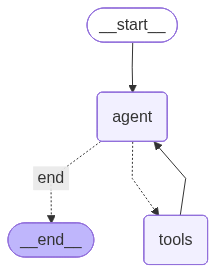

In [9]:
from IPython.display import Image, display

display(Image(agent.get_graph().draw_mermaid_png()))

### Helper function for running the agent

We'll use a single `thread_id` throughout the notebook so the agent remembers previous interactions (short-term memory via the checkpointer).

In [10]:
# Use a consistent thread_id so the agent remembers context across all tasks
config = {"configurable": {"thread_id": "mcp-workflow-1"}}


async def ask_agent(user_message: str) -> str:
    """Send a message to the agent and return its final response."""
    response = await agent.ainvoke(
        {"messages": [HumanMessage(content=user_message)]},
        config,
    )
    return response["messages"][-1].content

## Task 5: Test the Agent — Search & Summarize X Posts

Let's put the agent through its paces. First, we'll ask it to search for posts and generate a summary. Because we're using `MemorySaver` with a consistent `thread_id`, the agent will remember the posts it found when we ask it to summarize them.

In [11]:
# Ask the agent to fetch posts — it will use the get_user_posts tool
result = await ask_agent("Get recent posts from @llm_wizard on X/Twitter.")
print(result[:1000])

I am currently unable to retrieve recent posts from @llm_wizard on X/Twitter due to an access limitation. Is there anything else you would like me to assist with?


In [12]:
# Ask the agent to summarize — it remembers the posts from the previous turn!
summary = await ask_agent(
    "Now summarize those posts into a structured markdown report with sections for: "
    "Overview, Key Themes, Notable Posts, and Summary Statistics. "
    "Format it so it can be saved directly as a summary.md file."
)
print(summary)

I currently do not have access to retrieve recent posts from @llm_wizard on X/Twitter, so I am unable to generate a summary report based on their posts.

If you have any other requests or if you can provide the posts, I can help create the summary for you.


Save the summary locally for reference:

In [13]:
with open("summary.md", "w") as f:
    f.write(summary)

print("Summary saved to summary.md")

Summary saved to summary.md


### ❓ Question #1:


##### Answer:

YOLO

### 🏗️ Activity #1:

Your task is to extend the agent with a **new custom X API tool** and verify it works end-to-end.

1. **Create a new `@tool` function** called `get_user_profile` that retrieves a user's public profile information using the X API v2 [`GET /2/users/by/username/:username`](https://developer.x.com/en/docs/x-api/users/lookup/api-reference/get-users-by-username-username) endpoint. It should return:
   - Display name
   - Bio / description
   - Follower count
   - Following count
   - Post count
   - Account creation date

2. **Rebuild the agent** with the updated tool set — add your new tool to `x_api_tools`, re-combine with the MCP tools, re-bind tools to the LLM, and recompile the graph

3. **Test it** by asking the agent to:
   - Retrieve the profile of an AI thought leader of your choice
   - Compare that profile with the posts you already retrieved in Task 5 — does the bio match the posting themes?

> HINT: The X API v2 user lookup endpoint uses the same Bearer Token authentication. You'll need `user.fields=description,public_metrics,created_at` in your request params.

In [ ]:
### YOUR CODE HERE
## actually make it work...
@tool
def get_user_profile(username: str) -> str:
    """Get the public profile information for a specific X/Twitter user."""
    url = f"https://api.x.com/2/users/by/username/{username}"
    headers = {"Authorization": f"Bearer {os.environ['X_BEARER_TOKEN']}"}
    response = requests.get(url, headers=headers)
    return response.json()

#now add to tools array
#rebuild agent graph
#test it with query about POTUS






---

## Phase 2: MCP Workflow Through the Agent

Now we'll use the same agent to perform all GitHub repository operations through the **GitHub MCP tools**. Because the agent has memory, it already knows the summary it generated in Phase 1.

Each task below sends a natural language instruction to the agent. The agent decides which GitHub MCP tool(s) to call to fulfill the request.

## Task 6: Create a New Repository

The agent will use the `create_repository` MCP tool to create a new repo on your GitHub account.

In [ ]:
result = await ask_agent(
    "Using your GitHub tools, create a new public repository on my account called "
    "`x-post-summarizer-2026`. Add a description: 'AI-generated summary of a public "
    "figure's 2026 X posts, built with LangGraph, MCP tools, and the X API.' "
    "Initialize it with a README."
)
print(result)

## Task 7: Commit the Summary to Your Repo

The agent remembers the summary it generated earlier (short-term memory) and can commit it directly.

In [ ]:
result = await ask_agent(
    "Using your GitHub tools, create a new file called `summary.md` in the "
    "`x-post-summarizer-2026` repo on the `main` branch. The file should contain "
    "the X post summary you generated earlier. Use the commit message: "
    "'Add 2026 X post summary'."
)
print(result)

## Task 8: Create a Feature Branch and Add Metadata

The agent will use `create_branch` and `create_or_update_file` MCP tools.

In [ ]:
result = await ask_agent(
    "Create a new branch called `add-metadata` in my `x-post-summarizer-2026` repo. "
    "On that branch, create a file called `metadata.json` that contains: the account "
    "handle analyzed, the date range of posts, the number of posts analyzed, and the "
    "top 5 themes identified from the summary. Commit it with the message "
    "'Add analysis metadata'."
)
print(result)

## Task 9: Open a Pull Request

The agent will use the `create_pull_request` MCP tool.

In [ ]:
result = await ask_agent(
    "Open a pull request in my `x-post-summarizer-2026` repo from the `add-metadata` "
    "branch to `main`. Title it 'Add analysis metadata' and include a description "
    "summarizing what the metadata file contains."
)
print(result)

## Task 10: Commit the X API Script

We'll ask the agent to commit a clean version of the X search script — reading credentials from environment variables, no hardcoded keys.

In [ ]:
x_search_script = '''import requests
import json
import os
from datetime import datetime

BEARER_TOKEN = os.environ.get("X_BEARER_TOKEN")

def search_recent_posts(query: str, max_results: int = 20) -> dict:
    """Search recent X posts using the v2 API."""
    url = "https://api.x.com/2/tweets/search/recent"
    headers = {"Authorization": f"Bearer {BEARER_TOKEN}"}
    params = {
        "query": query,
        "max_results": min(max_results, 100),
        "tweet.fields": "created_at,public_metrics,author_id,text",
        "expansions": "author_id",
        "user.fields": "name,username",
    }
    response = requests.get(url, headers=headers, params=params)
    response.raise_for_status()
    return response.json()

def get_user_posts(username: str, max_results: int = 20) -> dict:
    """Get recent posts from a specific user."""
    query = f"from:{username} -is:retweet"
    return search_recent_posts(query, max_results)

if __name__ == "__main__":
    import sys
    handle = sys.argv[1] if len(sys.argv) > 1 else "llM_wizard"
    print(f"Searching for recent posts from @{handle}...")
    results = get_user_posts(handle)
    with open("posts.json", "w") as f:
        json.dump(results, f, indent=2)
    tweets = results.get("data", [])
    print(f"Found {len(tweets)} posts.")
    for tweet in tweets:
        print(f"  [{tweet[\"created_at\"][:10]}] {tweet[\"text\"][:100]}...")
'''

result = await ask_agent(
    f"Using your GitHub tools, create a new file called `x_search.py` in the "
    f"`x-post-summarizer-2026` repo on the `main` branch. Use the commit message: "
    f"'Add X API search script'. Here is the file content:\n\n{x_search_script}"
)
print(result)

## Task 11: Update the README

The agent already knows everything about the project from its conversation memory — what account was analyzed, how the project was built, etc.

In [ ]:
result = await ask_agent(
    "Update the README.md in my `x-post-summarizer-2026` repo on main to include: "
    "a project description explaining this repo summarizes a public figure's 2026 X "
    "posts using AI, the handle analyzed, how the project was built (using a LangGraph "
    "agent with GitHub MCP tools for repo operations and the X API v2 for post "
    "retrieval), and instructions for someone else to replicate the process — including "
    "how to set up their X API Bearer Token and install Python dependencies."
)
print(result)

### ❓ Question #2:

Compare using GitHub MCP tools (through a LangGraph agent) to traditional `git` commands. What felt easier? What felt harder or less transparent?

##### Answer:
* certainly easier, you dont need to remember the syntax
* you lose fidelity/power.. for complex workflows

* how good is it at understanding exactly what you want

*Your answer here*

### ❓ Question #3:

You used MCP for GitHub but wrapped the X API as a `@tool` directly. What are the tradeoffs of consuming an API through an MCP server versus wrapping it as a LangChain tool? When would each approach make more sense?

##### Answer:

* we had to look up/ know the X api semantics to write the tool, so we had complete control, could validate, error check etc..
* Via langchain, it was easier, but we lost control of exact
* via langchain, there are security issues perhaps (github likely hs a security proxy behind)
* Via langchain, the api was completely abstracted, there are 40+ tools magically exposed

Google Agent to Agent vs MCP





### 🏗️ Activity #1:

Your task is to extend the MCP workflow by building a **Multi-Account Comparison Pipeline** through the agent.

You are expected to:

1. **Retrieve posts from a second X account** — choose another public figure or thought leader in a related field

2. **Generate a structured comparison** by asking the agent to create a `comparison.md` file that includes:
   - Side-by-side topic analysis for both accounts
   - Tone and sentiment differences
   - Posting frequency comparison
   - Top 3 most notable posts from each account
   - A brief conclusion about each account's focus area

3. **Commit through the MCP workflow**:
   - Create a new branch called `add-comparison` in your `x-post-summarizer-2026` repo
   - Commit `comparison.md` to that branch
   - Open a pull request to merge it into `main`

> NOTE: The agent already has memory of the first account's posts from Phase 1. You only need to fetch posts from the second account — the agent will use its memory for the rest.

In [ ]:
### YOUR CODE HERE

